In [2]:
import os
import sys
from tqdm import trange
from tqdm import tqdm
from skimage.util import montage
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist.dataset import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal
from medmnist.evaluator import getAUC, getACC
from medmnist.info import INFO

In [3]:
print("Version:", medmnist.__version__)

Version: 2.2.3


In [4]:
data_flag = 'dermamnist'
# data_flag = 'breastmnist'
download = True
input_root = 'E:/外教课/medMNIST-main/data/'

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

flag_to_class = {
    "pathmnist": PathMNIST,
    "chestmnist": ChestMNIST,
    "dermamnist": DermaMNIST,
    "octmnist": OCTMNIST,
    "pneumoniamnist": PneumoniaMNIST,
    "retinamnist": RetinaMNIST,
    "breastmnist": BreastMNIST,
    "organmnist_axial": OrganMNISTAxial,
    "organmnist_coronal": OrganMNISTCoronal,
    "organmnist_sagittal": OrganMNISTSagittal,
}

DataClass = flag_to_class[data_flag]

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(root=input_root, split='train', transform=data_transform, download=download)
test_dataset = DataClass(root=input_root, split='test', transform=data_transform, download=download)
nonorm_dataset = DataClass(root=input_root, split='train', transform=transforms.ToTensor(), download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 19725078/19725078 [00:03<00:00, 5940314.34it/s]


Using downloaded and verified file: E:/外教课/medMNIST-main/data/dermamnist.npz
Using downloaded and verified file: E:/外教课/medMNIST-main/data/dermamnist.npz


In [6]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(nonorm_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: E:/外教课/medMNIST-main/data/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root 

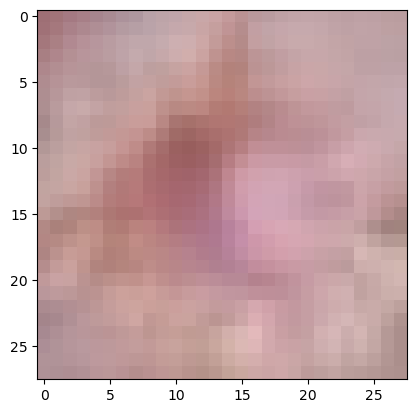

In [7]:
# visualization

img, target = nonorm_dataset[0]
if n_channels == 1:
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
else:
    img = img.permute(1, 2, 0)
    plt.imshow(img)

Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [9]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Next, we can start to train and evaluate!

In [10]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:20<00:00,  2.74it/s]


In [13]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                m = nn.Sigmoid()
                outputs = m(outputs)
            else:
                targets = targets.squeeze().long()
                m = nn.Softmax(dim=1)
                outputs = m(outputs)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
    
        print('%s  acc: %.3f  auc:%.3f' % (split, acc, auc))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  acc: 0.704  auc:0.889
test  acc: 0.684  auc:0.877


In [19]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小为 (224, 224)
    transforms.ToTensor(),
])

# Load DermaMNIST dataset
train_dataset = DataClass(root=input_root, split='train', transform=transform, download=download)
test_dataset = DataClass(root=input_root, split='test', transform=transform, download=download)


Using downloaded and verified file: E:/外教课/medMNIST-main/data/dermamnist.npz
Using downloaded and verified file: E:/外教课/medMNIST-main/data/dermamnist.npz


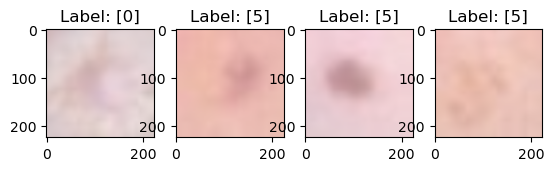

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_dataset is an instance of your dataset
# Iterate through the first few samples in the training dataset
for i, (inputs, labels) in enumerate(train_dataset):
    # Convert the PyTorch tensor to a NumPy array
    image = inputs.numpy()
    
    # Unnormalize the image (if normalization was applied during data transformation)
    image = image * 0.5 + 0.5  # Assuming normalization with mean=0.5, std=0.5
    
    # Transpose the image tensor to (C, H, W) from (H, W, C)
    image = np.transpose(image, (1, 2, 0))
    
    # Plot the image
    plt.subplot(1, 4, i+1)  # Assuming you want to plot 4 images in a row
    plt.imshow(image)
    plt.title(f"Label: {labels}")


    if i == 3:  # Break after plotting the first 4 images
        break

plt.show()


In [38]:
for inputs, labels in train_dataset:
    print(labels)  # 打印输入图像的大小
 


[0]
[5]
[5]
[5]
[4]
[5]
[4]
[5]
[5]
[5]
[2]
[5]
[1]
[5]
[4]
[5]
[2]
[5]
[5]
[5]
[5]
[5]
[5]
[6]
[2]
[5]
[5]
[5]
[5]
[5]
[2]
[4]
[5]
[1]
[5]
[4]
[5]
[4]
[5]
[4]
[5]
[5]
[5]
[2]
[2]
[5]
[5]
[2]
[5]
[6]
[4]
[5]
[5]
[5]
[5]
[2]
[5]
[4]
[5]
[5]
[4]
[5]
[5]
[1]
[0]
[5]
[0]
[3]
[0]
[5]
[5]
[2]
[0]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[4]
[2]
[5]
[2]
[4]
[0]
[5]
[1]
[5]
[4]
[5]
[5]
[6]
[5]
[2]
[5]
[5]
[5]
[1]
[5]
[5]
[5]
[4]
[5]
[2]
[2]
[5]
[5]
[4]
[5]
[2]
[5]
[5]
[5]
[5]
[2]
[5]
[5]
[4]
[4]
[5]
[5]
[5]
[5]
[3]
[5]
[4]
[5]
[2]
[5]
[5]
[5]
[2]
[5]
[5]
[5]
[6]
[5]
[0]
[5]
[5]
[4]
[5]
[5]
[5]
[5]
[5]
[2]
[5]
[5]
[5]
[5]
[5]
[2]
[5]
[4]
[1]
[5]
[2]
[1]
[4]
[5]
[5]
[5]
[0]
[5]
[5]
[4]
[5]
[4]
[2]
[5]
[5]
[5]
[0]
[5]
[4]
[5]
[5]
[4]
[2]
[5]
[5]
[4]
[2]
[1]
[5]
[5]
[5]
[5]
[1]
[5]
[5]
[0]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[1]
[5]
[1]
[1]
[5]
[5]
[5]
[5]
[5]
[2]
[5]
[5]
[6]
[5]
[1]
[1]
[5]
[2]
[5]
[5]
[5]
[5]
[5]
[5]
[4]
[5]
[2]
[5]
[5]
[5]
[5]
[5]
[5]
[4]
[5]
[5]
[5]
[5]
[2]
[1]
[5]
[2]
[1]
